# Word2Vec then RNN

## Load data

In [1]:
import pandas as pd
import numpy as np
from os import path

importDirectory = "../state/data/preprocessed-train-test/"

train, test, data, contestTest = map(
    lambda filename: pd.read_csv(path.join(importDirectory, filename)), 
    ["train.csv", "test.csv", "all.csv", "contest-test.csv"])

In [2]:
print("train: {}, test: {}, all: {}, contestTest: {}".format(
    train.shape, test.shape, data.shape, contestTest.shape))

train: (127656, 8), test: (31915, 8), all: (159571, 8), contestTest: (153164, 2)


In [3]:
def splitSentences(dataset):
    return (dataset.comment_text
    .str.replace("[^A-Za-z\s]", "")
    .str.lower()
    .str.split())

In [4]:
%%time
splitTrain = splitSentences(train)
splitTest = splitSentences(test)

CPU times: user 2.92 s, sys: 136 ms, total: 3.06 s
Wall time: 3.06 s


## Convert words to integers

In [5]:
from sklearn.preprocessing import LabelEncoder

allWords = set([word for sentence in pd.concat([splitTrain, splitTest]) for word in sentence])

In [6]:
wordToInteger = { word: index for index, word in enumerate(allWords) }
integerToWord = { index: word for index, word in enumerate(allWords) }

In [7]:
integerTrain = splitTrain.apply(lambda sentence: [wordToInteger[word] for word in sentence])
integerTest = splitTest.apply(lambda sentence: [wordToInteger[word] for word in sentence])

## Int2Vec embedding matrix

In [8]:
numDimensions = 50
maxSeqLength = 250

In [13]:
def loadw2vModel(filepath):
    return (gensim
    .models
    .KeyedVectors
    .load_word2vec_format(filepath))
                
def loadGlovew2v(ndim):
    return loadw2vModel("../state/external-models/glove.6B/w2v.glove.6B.{}.txt".format(ndim))

In [ ]:
%%time
import gensim

# w2vModel = loadw2vModel("../state/external-models/glove.6B/w2v.glove.840B.300d.txt")
# w2vModel = loadGlovew2v(50)

In [98]:
availableWords = set.intersection(allWords, set(w2vModel.vocab.keys()))

In [99]:
np.random.seed(432432)

int2vec = {index: w2vModel.word_vec(word) 
             if word in availableWords 
             else np.random.normal(scale=.644, size=(numDimensions,))
         for index, word in integerToWord.items()}

In [100]:
embeddingMatrix = np.array([vector for vector in int2vec.values()])

## Oversample

In [101]:
def oversample(dataset, label): 
    multiples = int(dataset[dataset[label] == 0].shape[0] / dataset[dataset[label] == 1].shape[0])
    
    datasetPositive = dataset[dataset[label] == 1]
    
    return pd.concat([dataset] + multiples * [datasetPositive]).reset_index()

In [102]:
trainOversampled = oversample(train, "toxic")

## Zero pad vectors

In [103]:
def padArrayWithZeros(array):
    fullArray = np.zeros(maxSeqLength)
    fullArray[:min(array.shape[0], maxSeqLength)] = array[:min(array.shape[0], maxSeqLength)]
    return fullArray

In [104]:
def prepareText(dataset):
    return np.array(splitSentences(dataset)
        .apply(lambda sentence: 
            padArrayWithZeros(np.array([
                wordToInteger[word]
                for word in sentence])))
        .tolist())

In [105]:
%%time
trainSentences = prepareText(trainOversampled)

CPU times: user 10.4 s, sys: 500 ms, total: 10.9 s
Wall time: 10.9 s


In [106]:
trainLabels = np.array(trainOversampled
    .toxic
    .apply(lambda label: np.array([0, 1]) if label == 1 else np.array([1, 0]))
    .tolist())

In [107]:
testSentences = prepareText(test)

In [108]:
testLabels = np.array(test
    .toxic
    .apply(lambda label: np.array([0, 1]) if label == 1 else np.array([1, 0]))
    .tolist())

In [109]:
# Small datasets
smallSize = 10000
trainSentences = trainSentences[:smallSize]
trainLabels = trainLabels[:smallSize]
testSentences = testSentences[:smallSize]
testLabels = testLabels[:smallSize]

## LMST RNN with keras

### Define the model

In [110]:
lstmUnits = [100]
numClasses = 2
batchSize = 1024

In [111]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 209976574376297996
]


In [112]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, Dropout, Embedding
from keras.optimizers import Adam
from keras_train_helper import tfauc

In [113]:
model = Sequential()

model.add(Embedding(
    embeddingMatrix.shape[0],
    embeddingMatrix.shape[1],
    weights=[embeddingMatrix],
    input_length=maxSeqLength,
    trainable=False))

model.add(LSTM(lstmUnits[0], name="LSTM"))

model.add(Dropout(.2, name="dropout"))

model.add(Dense(
    2, 
    activation="softmax", 
    name="softmax_output"))

model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=[tfauc])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 100)          22396600  
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 2)                 202       
Total params: 22,477,202
Trainable params: 80,602
Non-trainable params: 22,396,600
_________________________________________________________________
None


### Train the model

In [114]:
tf.set_random_seed(43245)
np.random.seed(453252)

In [115]:
from keras_train_helper import rotateTensorboardLogs

rotateTensorboardLogs()

In [116]:
from keras.callbacks import TensorBoard
from keras_train_helper import PrintAucCallback

tensorBoardCallback = TensorBoard(log_dir="./tb-logs")
printAucCallback = PrintAucCallback(testSentences, testLabels, allTestDataPerEpochs=1)

In [118]:
%%time
model.fit(
    trainSentences, 
    trainLabels, 
    nb_epoch=3, 
    batch_size=batchSize,
    callbacks=[tensorBoardCallback, printAucCallback])

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
10000/10000 [==============================] - 47s 5ms/step - loss: 0.3193 - tfauc: 0.9047
Epoch 2/3
10000/10000 [==============================] - 46s 5ms/step - loss: 0.3189 - tfauc: 0.9050
Epoch 3/3
10000/10000 [==============================] - 47s 5ms/step - loss: 0.3184 - tfauc: 0.9050
CPU times: user 7min 26s, sys: 16.4 s, total: 7min 42s
Wall time: 2min 20s


## Evaluate on test data

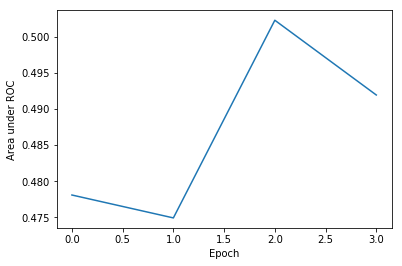

In [54]:
import matplotlib.pyplot as plt
plt.plot([value for key, value in printAucCallback.listOfAucs])

plt.ylabel("Area under ROC")
plt.xlabel("Epoch")
plt.show()

           P Neutral  P Toxic
T Neutral       9021        0
T Toxic          977        2


           P Neutral  P Toxic
T Neutral     0.9021   0.0000
T Toxic       0.0977   0.0002


0.004


0.3193


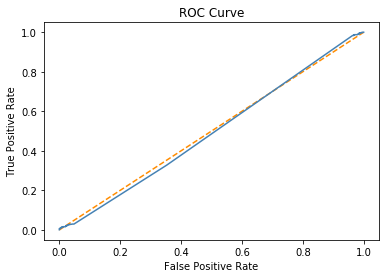

In [48]:
from evaluate_predictions import evaluatePredictions

predictions = model.predict(testSentences, batch_size=batchSize)
binaryPredictions = np.where(predictions[:, 1] > 0.5, 1, 0)
labels = testLabels[:, 1]

evaluatePredictions(pd.Series(labels), binaryPredictions, predictions)